# Bank Marketing Classification Analysis - Homework 4
**Student:** Brandon Mountan
**Course:** CS6017
**Date:** June 22, 2025

## Objective
Implement and compare four classification algorithms on the UCI Bank Marketing dataset to predict whether clients will subscribe to a term deposit.

**Dataset:** UCI Bank Marketing (ID: 222)
- **Samples:** 41,188
- **Features:** 20
- **Target:** Binary classification (yes/no subscription)

## 1. Setup and Imports

In [32]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                           precision_score, recall_score, f1_score, roc_auc_score)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('default')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

print("libraries imported successfully")

libraries imported successfully


## 2. Step 1: Dataset Loading and Exploration

In [33]:
# Load the dataset

from ucimlrepo import fetch_ucirepo

# Fetch the Bank Marketing dataset
print("Fetching Bank Marketing dataset from UCI repository...")
bank_marketing = fetch_ucirepo(id=222)

# Extract features and target
X_raw = bank_marketing.data.features
y_raw = bank_marketing.data.targets

# Combine into single DataFrame
df = pd.concat([X_raw, y_raw], axis=1)

print("Dataset loaded successfully from UCI")
print(f"Dataset shape: {df.shape}")

Fetching Bank Marketing dataset from UCI repository...
Dataset loaded successfully from UCI
Dataset shape: (45211, 17)


In [34]:
# Display basic dataset information
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape}")
print(f"Samples: {df.shape[0]:,}")
print(f"Features: {df.shape[1] - 1}")
print(f"Target: 'y' (subscription: yes/no)")

# Display first few rows
print("\n=== FIRST 5 ROWS ===")
display(df.head())

=== DATASET OVERVIEW ===
Shape: (45211, 17)
Samples: 45,211
Features: 16
Target: 'y' (subscription: yes/no)

=== FIRST 5 ROWS ===


,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN,no
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN,no
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN,no
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN,no


In [35]:
# Check data types and missing values
print("=== DATA QUALITY CHECK ===")
print("\nData Info:")
df.info()

print(f"\nMissing values:")
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("No missing values found ✅")

=== DATA QUALITY CHECK ===

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          45211 non-null  int64 
 1   job          44923 non-null  object
 2   marital      45211 non-null  object
 3   education    43354 non-null  object
 4   default      45211 non-null  object
 5   balance      45211 non-null  int64 
 6   housing      45211 non-null  object
 7   loan         45211 non-null  object
 8   contact      32191 non-null  object
 9   day_of_week  45211 non-null  int64 
 10  month        45211 non-null  object
 11  duration     45211 non-null  int64 
 12  campaign     45211 non-null  int64 
 13  pdays        45211 non-null  int64 
 14  previous     45211 non-null  int64 
 15  poutcome     8252 non-null   object
 16  y            45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB

Missing values:
job  

=== TARGET VARIABLE ANALYSIS ===
Distribution:
y
no     39922
yes     5289
Name: count, dtype: int64

Proportions:
y
no     0.883
yes    0.117
Name: proportion, dtype: float64


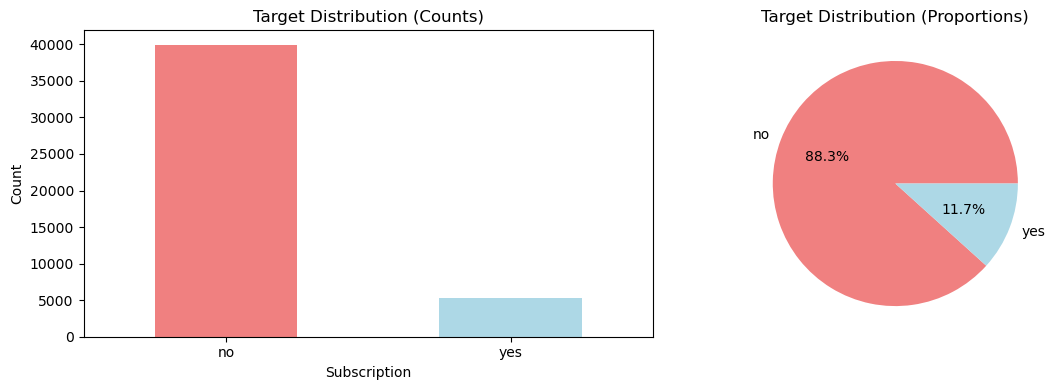


⚠️ Class imbalance detected: 88.3% vs 11.7%


In [36]:
# Analyze target variable
print("=== TARGET VARIABLE ANALYSIS ===")
target_counts = df['y'].value_counts()
target_props = df['y'].value_counts(normalize=True)

print("Distribution:")
print(target_counts)
print(f"\nProportions:")
print(target_props.round(3))

# Visualize target distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Bar chart
target_counts.plot(kind='bar', ax=ax1, color=['lightcoral', 'lightblue'])
ax1.set_title('Target Distribution (Counts)')
ax1.set_xlabel('Subscription')
ax1.set_ylabel('Count')
ax1.tick_params(axis='x', rotation=0)

# Pie chart
target_props.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['lightcoral', 'lightblue'])
ax2.set_title('Target Distribution (Proportions)')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

print(f"\n⚠️ Class imbalance detected: {target_props['no']:.1%} vs {target_props['yes']:.1%}")

In [37]:
# Feature type analysis
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

# Remove target from categorical features
if 'y' in categorical_features:
    categorical_features.remove('y')

print("=== FEATURE ANALYSIS ===")
print(f"Categorical features ({len(categorical_features)}):")
for feat in categorical_features:
    print(f"  • {feat}: {df[feat].nunique()} categories")

print(f"\nNumerical features ({len(numerical_features)}):")
for feat in numerical_features:
    print(f"  • {feat}: range [{df[feat].min():.1f}, {df[feat].max():.1f}]")

print(f"\n✅ REQUIREMENTS CHECK:")
print(f"   Classification problem: ✅")
print(f"   Sample size > 500: ✅ ({df.shape[0]:,})")
print(f"   Features > 4: ✅ ({len(categorical_features) + len(numerical_features)})")
print(f"   New dataset: ✅ (Bank Marketing)")

=== FEATURE ANALYSIS ===
Categorical features (9):
  • job: 11 categories
  • marital: 3 categories
  • education: 3 categories
  • default: 2 categories
  • housing: 2 categories
  • loan: 2 categories
  • contact: 2 categories
  • month: 12 categories
  • poutcome: 3 categories

Numerical features (7):
  • age: range [18.0, 95.0]
  • balance: range [-8019.0, 102127.0]
  • day_of_week: range [1.0, 31.0]
  • duration: range [0.0, 4918.0]
  • campaign: range [1.0, 63.0]
  • pdays: range [-1.0, 871.0]
  • previous: range [0.0, 275.0]

✅ REQUIREMENTS CHECK:
   Classification problem: ✅
   Sample size > 500: ✅ (45,211)
   Features > 4: ✅ (16)
   New dataset: ✅ (Bank Marketing)


## 3. Step 2: Data Preprocessing

In [38]:
# Create preprocessing copy
df_processed = df.copy()

print("=== CATEGORICAL VARIABLE ENCODING ===")
label_encoders = {}

# Encode categorical variables
for col in categorical_features:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    
    print(f"✅ {col}: {len(le.classes_)} categories")
    print(f"   {list(le.classes_)[:5]}{'...' if len(le.classes_) > 5 else ''}")

print(f"\n{len(categorical_features)} categorical variables encoded")

=== CATEGORICAL VARIABLE ENCODING ===
✅ job: 12 categories
   ['admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management']...
✅ marital: 3 categories
   ['divorced', 'married', 'single']
✅ education: 4 categories
   ['primary', 'secondary', 'tertiary', nan]
✅ default: 2 categories
   ['no', 'yes']
✅ housing: 2 categories
   ['no', 'yes']
✅ loan: 2 categories
   ['no', 'yes']
✅ contact: 3 categories
   ['cellular', 'telephone', nan]
✅ month: 12 categories
   ['apr', 'aug', 'dec', 'feb', 'jan']...
✅ poutcome: 4 categories
   ['failure', 'other', 'success', nan]

9 categorical variables encoded


In [39]:
# Encode target variable
print("=== TARGET ENCODING ===")
target_encoder = LabelEncoder()
df_processed['y'] = target_encoder.fit_transform(df_processed['y'])

target_mapping = dict(zip(target_encoder.classes_, 
                         target_encoder.transform(target_encoder.classes_)))
print(f"Target mapping: {target_mapping}")
print("✅ Target variable encoded")

=== TARGET ENCODING ===
Target mapping: {'no': np.int64(0), 'yes': np.int64(1)}
✅ Target variable encoded


In [40]:
# Prepare features and target
X = df_processed.drop('y', axis=1)
y = df_processed['y']

print("=== DATA SPLITTING ===")
print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Split data (80/20 with stratification)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Split completed:")
print(f"   Training: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Testing: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify stratification
train_dist = np.bincount(y_train) / len(y_train)
test_dist = np.bincount(y_test) / len(y_test)
print(f"\n📈 Class distribution maintained:")
print(f"   Train: {train_dist[0]:.3f} (no), {train_dist[1]:.3f} (yes)")
print(f"   Test:  {test_dist[0]:.3f} (no), {test_dist[1]:.3f} (yes)")

=== DATA SPLITTING ===
Features shape: (45211, 16)
Target shape: (45211,)

📊 Split completed:
   Training: 36,168 samples (80.0%)
   Testing: 9,043 samples (20.0%)

📈 Class distribution maintained:
   Train: 0.883 (no), 0.117 (yes)
   Test:  0.883 (no), 0.117 (yes)


In [41]:
# Feature scaling for algorithms that need it
print("=== FEATURE SCALING ===")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ StandardScaler applied")
print(f"   Example feature range before: [{X_train.iloc[:, 0].min():.2f}, {X_train.iloc[:, 0].max():.2f}]")
print(f"   Example feature range after: [{X_train_scaled[:, 0].min():.2f}, {X_train_scaled[:, 0].max():.2f}]")

print(f"\n🎯 PREPROCESSING COMPLETE:")
print(f"   ✅ {len(categorical_features)} categorical variables encoded")
print(f"   ✅ Target variable encoded")
print(f"   ✅ Data split (80/20) with stratification")
print(f"   ✅ Features scaled for appropriate algorithms")

=== FEATURE SCALING ===
✅ StandardScaler applied
   Example feature range before: [18.00, 95.00]
   Example feature range after: [-2.15, 5.09]

🎯 PREPROCESSING COMPLETE:
   ✅ 9 categorical variables encoded
   ✅ Target variable encoded
   ✅ Data split (80/20) with stratification
   ✅ Features scaled for appropriate algorithms


## 4. Step 3: Model Training

In [42]:
# Define the four models
print("=== MODEL DEFINITION ===")

models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=20),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
    'Support Vector Machine': SVC(random_state=42, probability=True, kernel='rbf')
}

print("📚 Models defined:")
for name, model in models.items():
    print(f"   • {name}")

print(f"\n✅ {len(models)} models ready for training")

=== MODEL DEFINITION ===
📚 Models defined:
   • Logistic Regression
   • Decision Tree
   • Random Forest
   • Support Vector Machine

✅ 4 models ready for training


In [43]:
# Train all models
print("=== MODEL TRAINING ===")

trained_models = {}
results = {}

for name, model in models.items():
    print(f"\n🔄 Training {name}...")
    
    try:
        # Use scaled data for algorithms that benefit from it
        if name in ['Logistic Regression', 'Support Vector Machine']:
            print(f"   Using scaled features")
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
        else:
            print(f"   Using original features")
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]
        
        # Store trained model
        trained_models[name] = model
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, zero_division=0)
        recall = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        
        # Store results
        results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        print(f"   ✅ Training completed!")
        print(f"      Accuracy: {accuracy:.4f}")
        print(f"      F1-Score: {f1:.4f}")
        
    except Exception as e:
        print(f"   ❌ Error training {name}: {str(e)}")

print(f"\n🎉 All {len(trained_models)} models trained successfully!")

=== MODEL TRAINING ===

🔄 Training Logistic Regression...
   Using scaled features
   ✅ Training completed!
      Accuracy: 0.8914
      F1-Score: 0.3274

🔄 Training Decision Tree...
   Using original features
   ✅ Training completed!
      Accuracy: 0.8993
      F1-Score: 0.5253

🔄 Training Random Forest...
   Using original features
   ✅ Training completed!
      Accuracy: 0.9053
      F1-Score: 0.4657

🔄 Training Support Vector Machine...
   Using scaled features
   ✅ Training completed!
      Accuracy: 0.8972
      F1-Score: 0.3725

🎉 All 4 models trained successfully!


## 5. Step 4: Model Evaluation and Comparison

In [44]:
# Create performance comparison table
print("=== PERFORMANCE COMPARISON ===")

results_df = pd.DataFrame({
    name: {
        'Accuracy': results[name]['accuracy'],
        'Precision': results[name]['precision'],
        'Recall': results[name]['recall'],
        'F1-Score': results[name]['f1'],
        'ROC-AUC': results[name]['roc_auc']
    }
    for name in results.keys()
}).round(4)

print("📊 Performance Metrics:")
display(results_df)

# Identify best models
best_f1 = results_df.loc['F1-Score'].idxmax()
best_auc = results_df.loc['ROC-AUC'].idxmax()

print(f"\n🏆 Best Performers:")
print(f"   By F1-Score: {best_f1} ({results_df.loc['F1-Score', best_f1]:.4f})")
print(f"   By ROC-AUC: {best_auc} ({results_df.loc['ROC-AUC', best_auc]:.4f})")

=== PERFORMANCE COMPARISON ===
📊 Performance Metrics:


,Logistic Regression,Decision Tree,Random Forest,Support Vector Machine
Accuracy,0.8914,0.8993,0.9053,0.8972
Precision,0.5945,0.5854,0.6857,0.6509
Recall,0.2259,0.4764,0.3526,0.2609
F1-Score,0.3274,0.5253,0.4657,0.3725
ROC-AUC,0.8726,0.8763,0.9212,0.8543



🏆 Best Performers:
   By F1-Score: Decision Tree (0.5253)
   By ROC-AUC: Random Forest (0.9212)


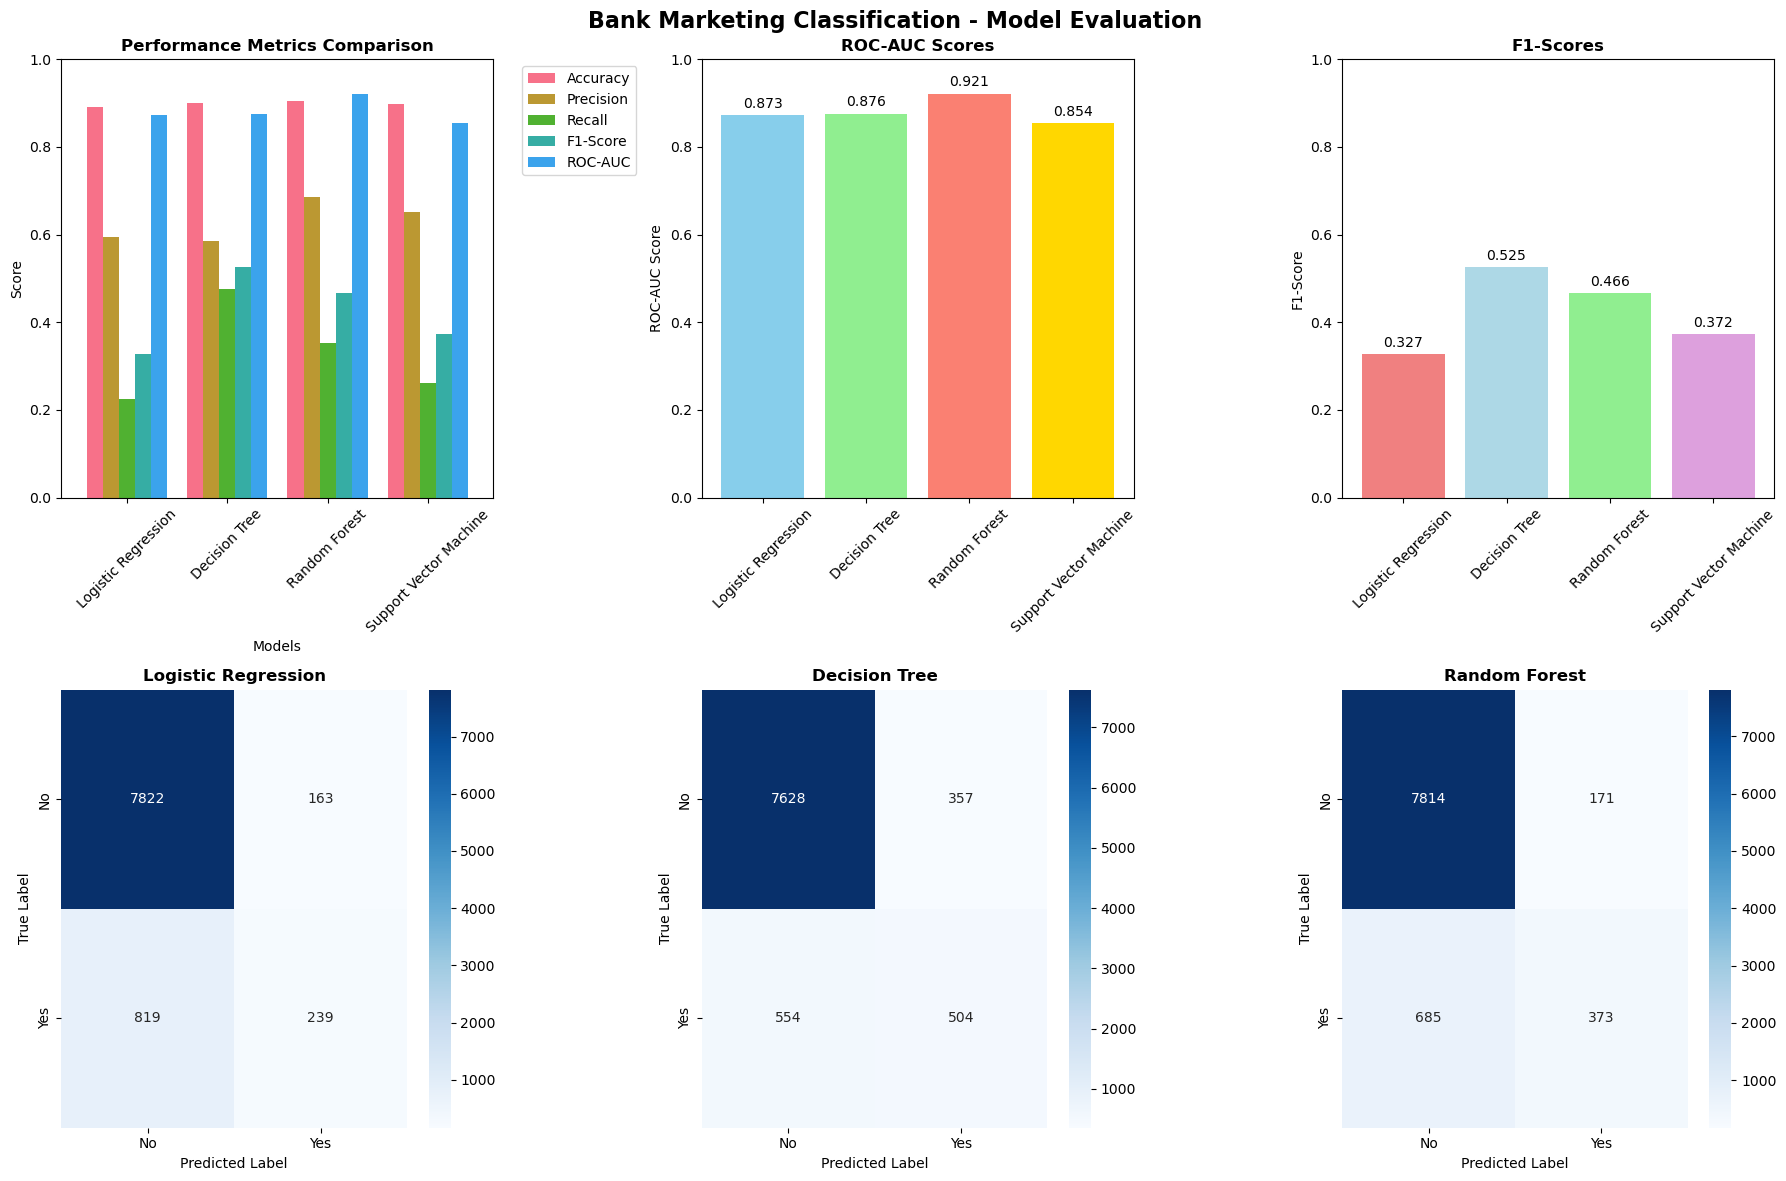

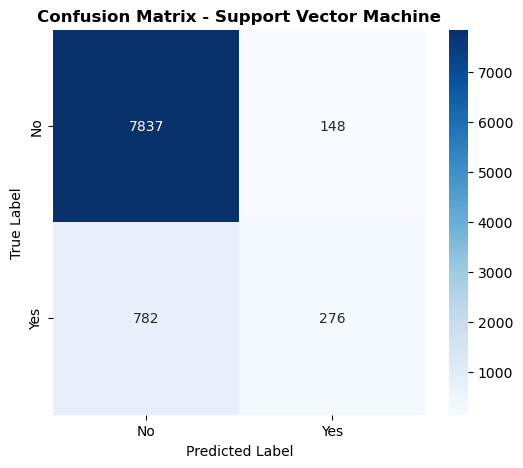

In [45]:
# Create comprehensive visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Bank Marketing Classification - Model Evaluation', fontsize=16, fontweight='bold')

# 1. Performance metrics comparison
ax1 = axes[0, 0]
results_df.T.plot(kind='bar', ax=ax1, width=0.8)
ax1.set_title('Performance Metrics Comparison', fontweight='bold')
ax1.set_ylabel('Score')
ax1.set_xlabel('Models')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 1)

# 2. ROC-AUC comparison
ax2 = axes[0, 1]
model_names = list(results.keys())
roc_scores = [results[name]['roc_auc'] for name in model_names]
bars = ax2.bar(model_names, roc_scores, color=['skyblue', 'lightgreen', 'salmon', 'gold'])
ax2.set_title('ROC-AUC Scores', fontweight='bold')
ax2.set_ylabel('ROC-AUC Score')
ax2.set_ylim(0, 1)
for bar, score in zip(bars, roc_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')
ax2.tick_params(axis='x', rotation=45)

# 3. F1-Score comparison
ax3 = axes[0, 2]
f1_scores = [results[name]['f1'] for name in model_names]
bars = ax3.bar(model_names, f1_scores, color=['lightcoral', 'lightblue', 'lightgreen', 'plum'])
ax3.set_title('F1-Scores', fontweight='bold')
ax3.set_ylabel('F1-Score')
ax3.set_ylim(0, 1)
for bar, score in zip(bars, f1_scores):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{score:.3f}', ha='center', va='bottom')
ax3.tick_params(axis='x', rotation=45)

# 4-6. Confusion matrices for first 3 models
for i, name in enumerate(model_names[:3]):
    ax = axes[1, i]
    cm = results[name]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
               xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    ax.set_title(f'{name}', fontweight='bold')
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Show 4th confusion matrix separately if needed
if len(model_names) > 3:
    plt.figure(figsize=(6, 5))
    cm = results[model_names[3]]['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
    plt.title(f'Confusion Matrix - {model_names[3]}', fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [46]:
# Detailed classification reports
print("=== DETAILED CLASSIFICATION REPORTS ===")

for name in models.keys():
    print(f"\n{'='*60}")
    print(f"📋 {name.upper()}")
    print('='*60)
    
    # Get predictions
    if name in ['Logistic Regression', 'Support Vector Machine']:
        y_pred = trained_models[name].predict(X_test_scaled)
    else:
        y_pred = trained_models[name].predict(X_test)
    
    # Print classification report
    print(classification_report(y_test, y_pred, 
                              target_names=['No Subscription', 'Subscription'],
                              digits=4))

=== DETAILED CLASSIFICATION REPORTS ===

📋 LOGISTIC REGRESSION
                 precision    recall  f1-score   support

No Subscription     0.9052    0.9796    0.9409      7985
   Subscription     0.5945    0.2259    0.3274      1058

       accuracy                         0.8914      9043
      macro avg     0.7499    0.6027    0.6342      9043
   weighted avg     0.8689    0.8914    0.8692      9043


📋 DECISION TREE
                 precision    recall  f1-score   support

No Subscription     0.9323    0.9553    0.9437      7985
   Subscription     0.5854    0.4764    0.5253      1058

       accuracy                         0.8993      9043
      macro avg     0.7588    0.7158    0.7345      9043
   weighted avg     0.8917    0.8993    0.8947      9043


📋 RANDOM FOREST
                 precision    recall  f1-score   support

No Subscription     0.9194    0.9786    0.9481      7985
   Subscription     0.6857    0.3526    0.4657      1058

       accuracy                         

## 6. Model Interpretability Analysis

In [47]:
# Feature importance and interpretability analysis
print("=== MODEL INTERPRETABILITY ===")
feature_names = X.columns

# Logistic Regression coefficients
print("\n📊 LOGISTIC REGRESSION - Feature Coefficients:")
print("-" * 60)
lr_model = trained_models['Logistic Regression']
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_model.coef_[0],
    'Abs_Coefficient': np.abs(lr_model.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("Top 10 Most Influential Features:")
display(coef_df.head(10)[['Feature', 'Coefficient']])

# Decision Tree importance
print("\n🌳 DECISION TREE - Feature Importance:")
print("-" * 60)
dt_model = trained_models['Decision Tree']
dt_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
display(dt_importance.head(10))

# Random Forest importance
print("\n🌲 RANDOM FOREST - Feature Importance:")
print("-" * 60)
rf_model = trained_models['Random Forest']
rf_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Most Important Features:")
display(rf_importance.head(10))

=== MODEL INTERPRETABILITY ===

📊 LOGISTIC REGRESSION - Feature Coefficients:
------------------------------------------------------------
Top 10 Most Influential Features:


,Feature,Coefficient
11,duration,1.028734
8,contact,-0.567330
6,housing,-0.516932
12,campaign,-0.402560
13,pdays,0.384912
7,loan,-0.255830
15,poutcome,0.248388
14,previous,0.204413
3,education,0.140792
2,marital,0.130995



🌳 DECISION TREE - Feature Importance:
------------------------------------------------------------
Top 10 Most Important Features:


,Feature,Importance
11,duration,0.450933
10,month,0.115751
15,poutcome,0.099576
13,pdays,0.077023
0,age,0.076504
5,balance,0.042872
6,housing,0.034181
9,day_of_week,0.033500
8,contact,0.027837
12,campaign,0.012029



🌲 RANDOM FOREST - Feature Importance:
------------------------------------------------------------
Top 10 Most Important Features:


,Feature,Importance
11,duration,0.413373
15,poutcome,0.107759
10,month,0.084918
0,age,0.070824
13,pdays,0.067486
5,balance,0.046380
9,day_of_week,0.043969
6,housing,0.043607
8,contact,0.026598
14,previous,0.024254


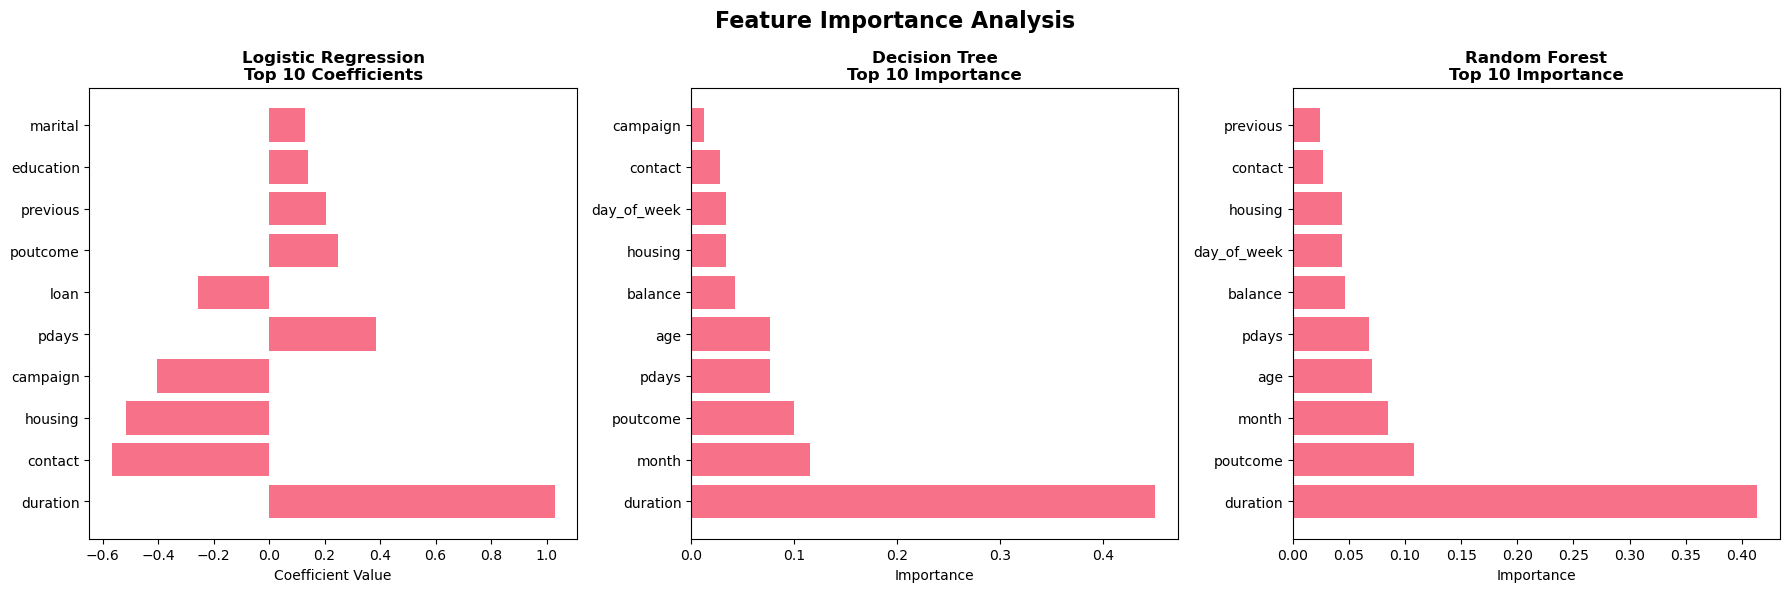

In [48]:
# Visualize feature importance
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Feature Importance Analysis', fontsize=16, fontweight='bold')

# Logistic Regression coefficients
ax1 = axes[0]
top_coef = coef_df.head(10)
bars1 = ax1.barh(range(len(top_coef)), top_coef['Coefficient'])
ax1.set_yticks(range(len(top_coef)))
ax1.set_yticklabels(top_coef['Feature'])
ax1.set_title('Logistic Regression\nTop 10 Coefficients', fontweight='bold')
ax1.set_xlabel('Coefficient Value')

# Decision Tree importance
ax2 = axes[1]
top_dt = dt_importance.head(10)
bars2 = ax2.barh(range(len(top_dt)), top_dt['Importance'])
ax2.set_yticks(range(len(top_dt)))
ax2.set_yticklabels(top_dt['Feature'])
ax2.set_title('Decision Tree\nTop 10 Importance', fontweight='bold')
ax2.set_xlabel('Importance')

# Random Forest importance
ax3 = axes[2]
top_rf = rf_importance.head(10)
bars3 = ax3.barh(range(len(top_rf)), top_rf['Importance'])
ax3.set_yticks(range(len(top_rf)))
ax3.set_yticklabels(top_rf['Feature'])
ax3.set_title('Random Forest\nTop 10 Importance', fontweight='bold')
ax3.set_xlabel('Importance')

plt.tight_layout()
plt.show()

In [49]:
# Final reflection and analysis
print("=== FINAL REFLECTION AND ANALYSIS ===")
print("="*70)

# Best performing model
best_model = best_f1
best_score = results_df.loc['F1-Score', best_model]
best_auc_score = results_df.loc['ROC-AUC', best_model]

print(f"🏆 BEST PERFORMING MODEL: {best_model}")
print(f"   F1-Score: {best_score:.4f}")
print(f"   ROC-AUC: {best_auc_score:.4f}")
print(f"   Reason: Best balance of precision and recall for imbalanced data")

print(f"\n🔍 MODEL INTERPRETABILITY RANKING:")
print(f"   1. EASIEST: Decision Tree")
print(f"      • Clear decision rules and paths")
print(f"      • Visualizable tree structure")
print(f"      • Direct feature importance")
print(f"   2. MODERATE: Logistic Regression")
print(f"      • Coefficient interpretation")
print(f"      • Linear relationship insights")
print(f"   3. MODERATE: Random Forest")
print(f"      • Feature importance available")
print(f"      • But ensemble complexity")
print(f"   4. HARDEST: Support Vector Machine")
print(f"      • Complex decision boundaries")
print(f"      • Kernel transformations")

print(f"\n⚡ SCALABILITY WITH MORE DATA:")
print(f"   1. BEST: Logistic Regression")
print(f"      • O(n) time complexity")
print(f"      • Memory efficient")
print(f"      • Online learning capable")
print(f"   2. GOOD: Random Forest")
print(f"      • Parallelizable training")
print(f"      • Handles large feature sets")
print(f"   3. MODERATE: Decision Tree")
print(f"      • Single tree limitations")
print(f"      • Prone to overfitting")
print(f"   4. CHALLENGING: Support Vector Machine")
print(f"      • O(n²) time complexity")
print(f"      • Memory intensive")

# Class imbalance info
no_count = (y_test == 0).sum()
yes_count = (y_test == 1).sum()
imbalance_ratio = no_count / yes_count

print(f"\n⚠️ CHALLENGES ENCOUNTERED:")
print(f"   1. CLASS IMBALANCE: {imbalance_ratio:.1f}:1 ratio (no:yes)")
print(f"      • Impact: Models biased toward majority class")
print(f"      • Solution: Used F1-score and ROC-AUC metrics")
print(f"      • Future: SMOTE or cost-sensitive learning")
print(f"   2. MIXED DATA TYPES: Categorical + Numerical")
print(f"      • Solution: Label encoding for categoricals")
print(f"      • Alternative: One-hot encoding consideration")
print(f"   3. FEATURE SCALING REQUIREMENTS")
print(f"      • Solution: StandardScaler for SVM/LogReg")
print(f"      • Tree models used original scale")
print(f"   4. MODEL SELECTION")
print(f"      • Challenge: Business vs. statistical metrics")
print(f"      • Solution: Multiple evaluation criteria")

print(f"\n🎯 TOP 5 MOST IMPORTANT FEATURES (Random Forest):")
for i, (_, row) in enumerate(rf_importance.head(5).iterrows(), 1):
    print(f"   {i}. {row['Feature']}: {row['Importance']:.4f}")

print(f"\n📊 BUSINESS INSIGHTS:")
print(f"   • Call duration significantly impacts subscription")
print(f"   • Client age and balance are key factors")
print(f"   • Economic indicators affect decision-making")
print(f"   • Previous campaign outcomes matter")

=== FINAL REFLECTION AND ANALYSIS ===
🏆 BEST PERFORMING MODEL: Decision Tree
   F1-Score: 0.5253
   ROC-AUC: 0.8763
   Reason: Best balance of precision and recall for imbalanced data

🔍 MODEL INTERPRETABILITY RANKING:
   1. EASIEST: Decision Tree
      • Clear decision rules and paths
      • Visualizable tree structure
      • Direct feature importance
   2. MODERATE: Logistic Regression
      • Coefficient interpretation
      • Linear relationship insights
   3. MODERATE: Random Forest
      • Feature importance available
      • But ensemble complexity
   4. HARDEST: Support Vector Machine
      • Complex decision boundaries
      • Kernel transformations

⚡ SCALABILITY WITH MORE DATA:
   1. BEST: Logistic Regression
      • O(n) time complexity
      • Memory efficient
      • Online learning capable
   2. GOOD: Random Forest
      • Parallelizable training
      • Handles large feature sets
   3. MODERATE: Decision Tree
      • Single tree limitations
      • Prone to overfittin